# What is TIER ?

### TIER Mobility is Europe's leading shared micro-mobility provider, with a mission to Change Mobility for Good. By providing people with a range of shared, light electric vehicles, from e-scooters to e-bikes and e-mopeds.

![alt text](Images/TIER.png)

# TIER API

The documentation of TIER API is available on the official website of the company : https://www.notion.so/TIER-MDS-API-v1-0-c76e5c4ea6564ce1ab82b4b8245a44a3

# Let's try it

You must insert `Authorization: Bearer ${API_KEY}` in the headers with your personal API key. To register for an API key send an email to api@tier.app.

### Get All available vehicles in a zone

To get all the vehicles available at a zone we can make a get request as follow :

In [5]:
import requests
import json
link = "https://platform.tier-services.io/v2/vehicle?zoneId=PARIS"
get_headers = {"X-Api-Key" : "YOUR_API_KEY_HERE"}
response = requests.get(link, headers = get_headers)
print(json.dumps(response.json(), indent=2))


{
  "data": [
    {
      "type": "vehicle",
      "id": "60423c0e-76a8-44ba-b6d2-8498bf93f592",
      "attributes": {
        "state": "ACTIVE",
        "lastLocationUpdate": "2021-10-19T22:58:06Z",
        "lastStateChange": "2021-10-17T01:33:29Z",
        "batteryLevel": 81,
        "lat": 48.869044,
        "lng": 2.414737,
        "maxSpeed": 5,
        "zoneId": "PARIS",
        "code": 126460,
        "iotVendor": "okai",
        "licencePlate": "126460",
        "isRentable": true,
        "vehicleType": "escooter",
        "hasHelmetBox": true,
        "hasHelmet": true
      }
    },
    {
      "type": "vehicle",
      "id": "b15048e6-d0e8-400a-9379-d15fa81211b7",
      "attributes": {
        "state": "ACTIVE",
        "lastLocationUpdate": "2021-10-19T22:54:16Z",
        "lastStateChange": "2021-10-17T23:55:37Z",
        "batteryLevel": 80,
        "lat": 48.881149159724416,
        "lng": 2.3243567628739163,
        "maxSpeed": 20,
        "zoneId": "PARIS",
        "code

As we can notice, the response of the API is a json file with id, state, battery level, location, ... of all TIER fleet in PARIS region

![alt text](Images/ResponseExample.png)

If you noticed in the response to the previous request, we had to deal only with escooter as a vehicletype but in fact there are 3 types of vehicles : 
- escooter
- emoped
- ebicycle

# Let's make a TIER data scrapper

The TIER API does not allow to have neither historical data of the movements of the fleet nor the monitoring of the locations through which a scooter has passed.

But there is a possibility to deduce this data, if we record the data returned by the API for a day.

By recording the data every minute, we will know if a vehicle has been used or not and where it was returned at the end of the ride

I will not publish the code to do this here, but it is not difficult to code it. You can get inspiration from the following code.

In [ ]:
import requests
import time
from datetime import datetime
starttime = time.time()

link = ""
get_headers = {"" : ""}

while True:
    try:
        timestamp = time.time()
        dt_object = datetime.fromtimestamp(timestamp)
        fileName = "data" + dt_object.strftime("%d-%m-%Y_%H%M%S")+".json"
        print(fileName)
        response = requests.get(link, headers = get_headers)
        with open(fileName, 'wb') as outf:
            outf.write(response.content)
        time.sleep(60.0 - ((time.time() - starttime) % 60.0))
    except:
        print("Error")
        time.sleep(10.0 - ((time.time() - starttime) % 10.0))

By letting your code run for a day, for example. Be careful not to let it run for forever, that would be scrapping and it's illegal.

I'm going to use some old data I have. (Same if u run your code for a while)

![alt text](Images/oldData.png)

## Centralizing data in a single file

As you can notice, the data is scattered over different files, and it would be better to use and analyze if all the data was on one file

We should write the content of all theses files in a unique CSV file by day. And for that, I have prepared the following code :

In [ ]:
import json
from datetime import datetime
import os

arr = os.listdir()
files_json = [thisFileName for thisFileName in arr if thisFileName.endswith('.json')]
sep = ";"
isSameDay = False
header = "timestamp;id;type;lastLocationUpdate;lastStateChange;batteryLevel;lat;lng;code;licencePlate;isRentable;vehicleType\n"
lastProcessedTimestampDay = "None"
for fileName in files_json:
    fileNameSplitted = fileName.split("R_")[1].split(".")
    fileDate = fileNameSplitted[0]
    timestamp = datetime.strptime(fileDate, "%d-%m-%Y_%H%M%S")
    print(timestamp)
    timestampDay = timestamp.strftime("%d-%m-%Y")
    if timestampDay == lastProcessedTimestampDay :
        isSameDay = True
    else :
        isSameDay = False
    lastProcessedTimestampDay = timestampDay
    print(timestampDay)
    timestamp = str(timestamp)
    currentWritingFile = str(timestampDay) + ".csv"
    if isSameDay == False :
        f = open(currentWritingFile, 'a', encoding='utf8')
        f.write(header)
        f.close()
    f = open(currentWritingFile, 'a', encoding='utf8')
    with open(fileName, encoding="utf-8") as json_file:
        data = json.load(json_file)
    for thisStation in data['data']:
        id = str(thisStation['id'])
        type = str(thisStation['type'])
        lastLocationUpdate = str(thisStation['attributes']['lastLocationUpdate'])
        lastStateChange = str(thisStation['attributes']['lastStateChange'])
        batteryLevel = str(thisStation['attributes']['batteryLevel'])
        lat = str(thisStation['attributes']['lat'])
        lng = str(thisStation['attributes']['lng'])
        code = str(thisStation['attributes']['code'])
        licencePlate = str(thisStation['attributes']['licencePlate'])
        isRentable = str(thisStation['attributes']['isRentable'])
        vehicleType = str(thisStation['attributes']['vehicleType'])
        f.write(timestamp + sep + id + sep + type + sep + lastLocationUpdate + sep + lastStateChange + sep + batteryLevel + sep + lat + sep +
                lng + sep + code + sep + licencePlate + sep + isRentable + sep + vehicleType + "\n")
    f.close()

That makes me two big csv files for the 2 days of which we have data

![alt text](Images/csvFiles.png)

# Using Pandas to read and manipulate the data

Now that we have CSV files, we can use the pandas library which is suited to the manipulation we want to do on these data

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime  
# reading csv file 
df = pd.read_csv("Data/01-06-2021.csv", sep=';')

C:\Users\salah\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [22]:
df.describe()

,batteryLevel,lat,lng,code
count,6.083154e+06,6.083154e+06,6.083154e+06,6.083154e+06
mean,6.110637e+01,4.885802e+01,2.333048e+00,2.023472e+05
std,2.436144e+01,1.882390e-02,3.783375e-02,4.792306e+04
min,0.000000e+00,4.879223e+01,2.222465e+00,1.264690e+05
25%,4.100000e+01,4.884506e+01,2.300796e+00,1.492460e+05
50%,6.100000e+01,4.885665e+01,2.332350e+00,2.261140e+05
75%,8.200000e+01,4.887222e+01,2.361565e+00,2.421570e+05
max,1.000000e+02,4.890091e+01,2.617999e+00,2.697090e+05


In [23]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [24]:
df.isna().sum()

timestamp             0
id                    0
type                  0
lastLocationUpdate    0
lastStateChange       0
batteryLevel          0
lat                   0
lng                   0
code                  0
licencePlate          0
isRentable            0
vehicleType           0
dtype: int64

## We try to identify the flow of rides per hour

Let's explain it using one escooter and then apply the same thing for all the fleet

In [25]:
df1 = df[["timestamp", "code", "lastLocationUpdate", "lastStateChange","lat", "lng", "vehicleType"]].copy(deep=True)
df1['lastStateChange'] =  pd.to_datetime(df1['lastStateChange'], format='%Y-%m-%dT%H:%M:%SZ')

In [26]:
df1['diffs_lastStateChange'] = df1.groupby(['code'])['lastStateChange'].transform(lambda x: x.diff()) 

In [27]:
df1['diffs_lastStateChange'].fillna(pd.Timedelta(seconds=0))

0         0 days
1         0 days
2         0 days
3         0 days
4         0 days
           ...  
6083149   0 days
6083150   0 days
6083151   0 days
6083152   0 days
6083153   0 days
Name: diffs_lastStateChange, Length: 6083154, dtype: timedelta64[ns]

In [28]:
df1.head(20)

,timestamp,code,lastLocationUpdate,lastStateChange,lat,lng,vehicleType,diffs_lastStateChange
0,2021-06-01 00:00:14,126469,2021-05-31T21:58:27Z,2021-05-30 10:20:29,48.851593,2.300192,escooter,NaT
1,2021-06-01 00:00:14,126473,2021-05-31T22:00:03Z,2021-05-30 08:16:03,48.854858,2.272905,escooter,NaT
2,2021-06-01 00:00:14,126480,2021-05-31T21:59:26Z,2021-05-27 21:32:49,48.848059,2.347147,escooter,NaT
3,2021-06-01 00:00:14,126500,2021-05-31T21:54:37Z,2021-05-29 13:48:05,48.841523,2.314234,escooter,NaT
4,2021-06-01 00:00:14,126501,2021-05-31T21:57:03Z,2021-05-30 09:51:01,48.834610,2.333682,escooter,NaT
5,2021-06-01 00:00:14,126503,2021-05-31T21:55:02Z,2021-05-30 10:33:56,48.866909,2.373323,escooter,NaT
6,2021-06-01 00:00:14,126504,2021-05-31T21:57:48Z,2021-05-31 02:47:27,48.870691,2.372726,escooter,NaT
7,2021-06-01 00:00:14,126508,2021-05-31T21:59:41Z,2021-05-29 03:22:54,48.866500,2.291126,escooter,NaT
8,2021-06-01 00:00:14,126510,2021-05-31T21:56:27Z,2021-05-30 22:29:50,48.877606,2.306287,escooter,NaT
9,2021-06-01 00:00:14,126511,2021-05-31T21:50:40Z,2021-05-28 21:47:08,48.829728,2.357696,escooter,NaT


In [31]:
df2 = df[["timestamp", "code", "lastLocationUpdate", "lastStateChange","lat", "lng", "vehicleType"]].copy(deep=True)
df2['diffs_lat'] = df1.groupby(['code'])['lat'].transform(lambda x: x.diff()) 
df2['diffs_lng'] = df1.groupby(['code'])['lng'].transform(lambda x: x.diff()) 

In [33]:
df2['diffs_lat'] = df2['diffs_lat'].fillna(0)
df2['diffs_lng'] = df2['diffs_lng'].fillna(0)

In [34]:
df2

,timestamp,code,lastLocationUpdate,lastStateChange,lat,lng,vehicleType,diffs_lat,diffs_lng
0,2021-06-01 00:00:14,126469,2021-05-31T21:58:27Z,2021-05-30T10:20:29Z,48.851593,2.300192,escooter,0.0,0.0
1,2021-06-01 00:00:14,126473,2021-05-31T22:00:03Z,2021-05-30T08:16:03Z,48.854858,2.272905,escooter,0.0,0.0
2,2021-06-01 00:00:14,126480,2021-05-31T21:59:26Z,2021-05-27T21:32:49Z,48.848059,2.347147,escooter,0.0,0.0
3,2021-06-01 00:00:14,126500,2021-05-31T21:54:37Z,2021-05-29T13:48:05Z,48.841523,2.314234,escooter,0.0,0.0
4,2021-06-01 00:00:14,126501,2021-05-31T21:57:03Z,2021-05-30T09:51:01Z,48.834610,2.333682,escooter,0.0,0.0
...,...,...,...,...,...,...,...,...,...
6083149,2021-06-01 23:59:14,269399,2021-06-01T21:56:19Z,2021-06-01T11:25:25Z,48.852650,2.287359,escooter,0.0,0.0
6083150,2021-06-01 23:59:14,269421,2021-06-01T21:49:23Z,2021-05-28T10:39:14Z,48.842408,2.286985,escooter,0.0,0.0
6083151,2021-06-01 23:59:14,269676,2021-06-01T21:59:02Z,2021-06-01T07:33:17Z,48.848565,2.285480,escooter,0.0,0.0
6083152,2021-06-01 23:59:14,269707,2021-06-01T21:52:41Z,2021-05-28T07:59:40Z,48.848813,2.318484,escooter,0.0,0.0


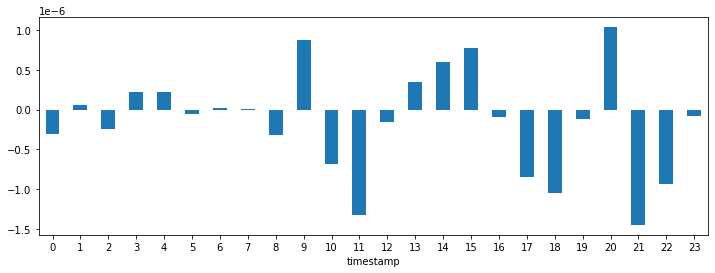

In [35]:
fig, axs = plt.subplots(figsize=(12, 4))
df2.groupby(df2["timestamp"].dt.hour)["diffs_lat"].mean().plot(kind='bar', rot=0, ax=axs)

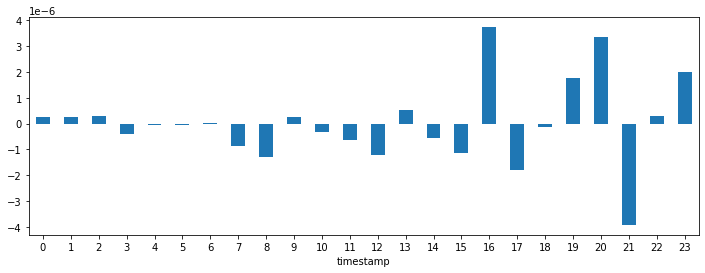

In [36]:
fig, axs = plt.subplots(figsize=(12, 4))
df2.groupby(df2["timestamp"].dt.hour)["diffs_lng"].mean().plot(kind='bar', rot=0, ax=axs)

Les deux figures précédentes montrent la moyenne de la différence de la latitude et la longitude à une heure H par rapport à H-1 par véhicules.

## The number of rides